# Water Levels
Banager Bridge station 25017, River Shannon

## Import data and datasets

In [4]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

# Suppressing warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

colour_pal = sns.color_palette('Paired')
#plt.style.use('fivethirtyeight') # - I am not sure I like this


In [5]:
# declare some constants
# https://www.youtube.com/watch?v=vV12dGe_Fho&t=132s

## correct for height above malin head
height = 30.330 # this is height of sensor 25017 above Malin Head
#df['DayMin'] = df['DayMin'] - height
'''
I want to calculate the floodline here, 
## Suggest last thursday is 3 feet above flood. - Dec 2023, check data for exact date! 17th?

Find scalar for flood level in M. I suggest 3m less one foot, 0.3048m

also import mean and percentile values from the waterlevels website, and compare them.
'''

field_flood = 3 - 0.3048 # in m - last estimate April 14th 2024 1ft water in field

print(field_flood)

2.6952


In [6]:
#importing the datasets

# https://waterlevel.ie/hydro-data/#/overview/Waterlevel/station/11617/Banagher/Qdownload

'''Dataset One - Water Levels values'''
# this dataset has the hourly readouts.
df = pd.read_csv('tsvalues.csv', sep=';', skiprows=10).iloc[:, :-1] # drop the water quality for now
df['Timestamp'] = df['#Timestamp']

df = df.set_index('Timestamp') # set the index

#issue is data is set = "%d/%m/%Y" - this should make this ok.
df.index = pd.to_datetime(df.index, format='mixed', dayfirst=True)
df['Value'] = df['Value'] - height # to recalibrate water level, keep colname value for now.


'''Dataset Two - Water Levels daily summary'''
# this dataset has one datapoint for each day. # dataset 2
df_daily = pd.read_csv('25017_banagher_s_complete.csv', skiprows=12).iloc[:, :-1] # for now exclude the quality column

df_daily = df_daily.set_index('Day') # set the index

#issue is data is set = "%d/%m/%Y" - this should make this ok.
df_daily.index = pd.to_datetime(df_daily.index, format='mixed', dayfirst=True)

# to recalibrate water levels # can do this in one line.
df_daily['Day Min'] = df_daily['Day Min'] - height 
df_daily['Day Mean'] = df_daily['Day Mean'] - height 
df_daily['Day Max'] = df_daily['Day Max'] - height 

Index(['Value'], dtype='object')
Variable   Type         Data/Info
---------------------------------
df         DataFrame                             <...>1218710 rows x 2 columns]
df_daily   DataFrame                Day Min  Day <...>n[12855 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12855 entries, 1989-01-02 to 2024-03-13
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Day Min   12855 non-null  float64
 1   Day Mean  12855 non-null  float64
 2   Day Max   12855 non-null  float64
dtypes: float64(3)
memory usage: 401.7 KB


In [15]:
'''Dataset Three - Water Temperature, Ten year dump'''
#station_name;Banagher
#station_no;25017
#station_latitude;53.19378667
#station_longitude;-7.993646667
#stationparameter_name;TWater
#ts_shortname;WEB.Cmd.P-Water-Temp
#ts_unitsymbol;°C
#WTO_OBJECT;SHANNON
#RBD;SHANNON RBD
#rows;80429
df_temp = pd.read_csv('tsvalues_temp.csv', sep=';', skiprows=10) 
#df = pd.read_csv('tsvalues.csv', sep=';', skiprows=10).iloc[:, :-1] # drop the water quality for now

df_temp.rename(columns={'#Timestamp': 'Timestamp'}, inplace=True)

df_temp = df_temp.set_index('Timestamp') # set the index

#issue is data is set = "%d/%m/%Y" - this should make this ok.
df_temp.index = pd.to_datetime(df_temp.index, format='mixed', dayfirst=True)

'''will rename this and work with it in a below section'''


'will rename this and work with it in a below section'

In [16]:
%whos DataFrame

Variable   Type         Data/Info
---------------------------------
df         DataFrame                             <...>n[80429 rows x 4 columns]
df_daily   DataFrame                Day Min  Day <...>n[12855 rows x 3 columns]
df_temp    DataFrame                             <...>n[80429 rows x 2 columns]


There are issues with outliers in all the datasets I suspect, when there was calibration and work done on the sensors I think.

In [11]:
df_daily.describe()  # there are issues in outliers here every now and then from the sensor which must be dropped

# this should be moved to it's own section below
NUMERICAL_FEATURES = df.select_dtypes(include=['int64', 'float64']).columns
print(NUMERICAL_FEATURES)

Index(['Value'], dtype='object')


## Initial Exploratory Data Analysis - Water Levels

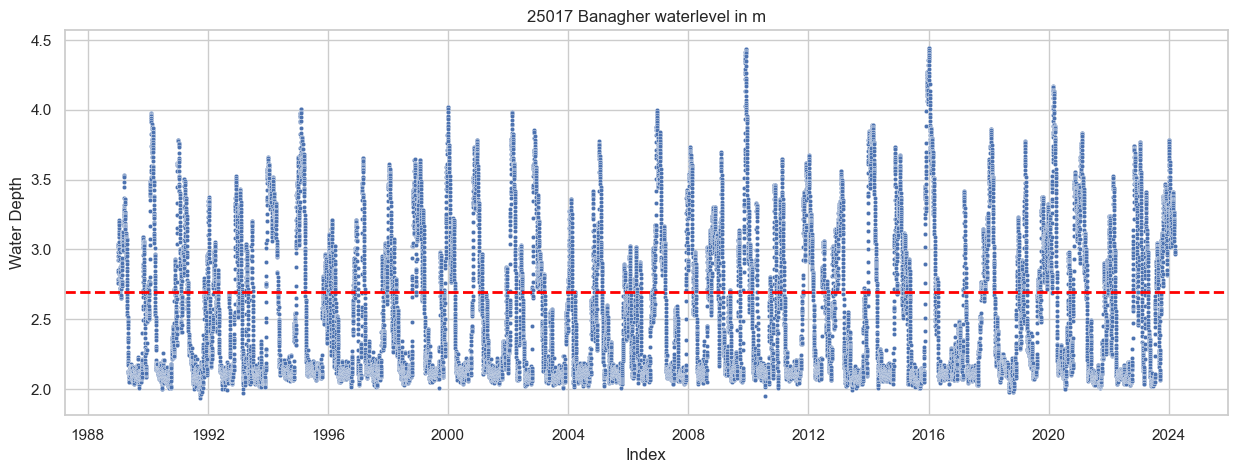

In [41]:
df_one_point = df.iloc[::48] # every 24th point to keep it simpler for this plot

#sns.set(style="whitegrid")
plt.figure(figsize=(15, 5))
sns.scatterplot(data=df_one_point, x=df_one_point.index, y='Value', s=10, palette=colour_pal)

plt.axhline(y=field_flood, color='red', linestyle='--', linewidth=2) # mark this name
# add quartile lines
plt.title('25017 Banagher waterlevel in m')
plt.xlabel('Index')
plt.ylabel('Water Depth')

# Show the plot
plt.show()

# this was the older plot
#df.plot(style='.', 
#        figsize=(15,5), 
#        color=colour_pal[0], 
#        title='25017 Banagher waterlevel in m',
#        markersize=1)
#plt.show()



#### Drop Outliers

In [23]:
def find_outliers(series, scale=3, quantiles=(0.25, 0.75)):
    
    Q1, Q3 = series.quantile(quantiles)

    IQR = Q3 - Q1
    lower_bound = Q1 - scale * IQR
    upper_bound = Q3 + scale * IQR

    return (lower_bound, upper_bound)

def describe_outliers(df_daily, scale=1.5, quantiles=(0.25, 0.75)):
 
    outlier_summary = {}

    for column in df_daily.columns:
        series = df_daily[column]

        (lower_bound, upper_bound) = find_outliers(series, scale, quantiles)

        # Identify and count outliers
        outliers = series[(series < lower_bound) | (series > upper_bound)]
        outlier_summary[column] = len(outliers)

    return outlier_summary

describe_outliers(df_daily) # to do all the columns at the same time


#df.index

{'Day Min': 181, 'Day Mean': 181, 'Day Max': 178}

In [24]:
def drop_outliers(df_daily, scale=1.5, quantiles=(0.25, 0.75)):
    #cleaned_df = df_daily.copy()  # Create a copy of the original DataFrame

    for column in df_daily.columns:
        series = df_daily[column]
        (lower_bound, upper_bound) = find_outliers(series, scale, quantiles)

        # Drop outliers
        outliers_index = (series < lower_bound) | (series > upper_bound)
        df_daily = df_daily[~outliers_index]

    return df_daily

df_daily = drop_outliers(df_daily)


describe_outliers(df_daily) # now check outliers again

{'Day Min': 0, 'Day Mean': 0, 'Day Max': 0}

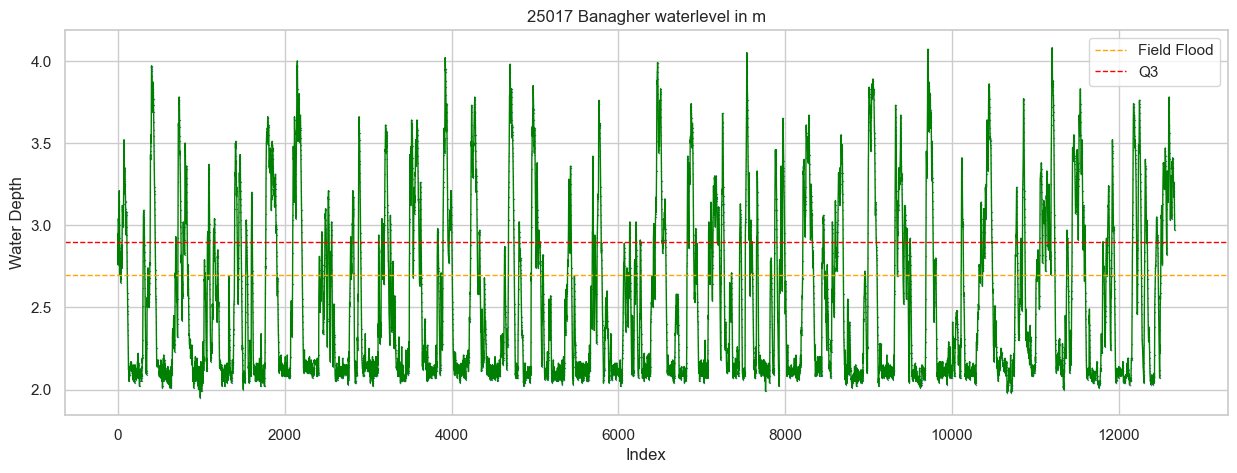

In [44]:
# plot daily values now that I have dropped the outliers

#df2.plot(style='.', 
#        figsize=(15,5), 
#        color=colour_pal[1], 
#        title='waterlevel in m, Dailies',
#        markersize=1)
#plt.show()

plt.figure(figsize=(15, 5))

# Resetting index to integers for plotting
#df_daily.reset_index(inplace=True)

sns.scatterplot(data=df_daily, x=df_daily.index, y='Day Mean', s=1)
plt.plot(df_daily.index, df_daily['Day Mean'], color='green', linewidth=1)

plt.axhline(y=field_flood, color='orange', linestyle='--', linewidth=1, label='Field Flood')

# Calculate quartiles
Q1 = df_daily['Day Mean'].quantile(0.25)
Q3 = df_daily['Day Mean'].quantile(0.75)

# Add quartile lines
#plt.axhline(y=Q1, color='blue', linestyle='--', linewidth=1, label='Q1')
plt.axhline(y=Q3, color='red', linestyle='--', linewidth=1, label='Q3')


plt.title('25017 Banagher waterlevel in m')
plt.xlabel('Index')
plt.ylabel('Water Depth')
plt.legend()
plt.show()


### Train / Test Split

In [12]:
# later I will change this to full cross validation
#https://machinelearningmastery.com/xgboost-for-regression/
#I should be able to replace with this
'''This entire section is probably redundant as I can use cross validation instead of splitting into train/test.'''

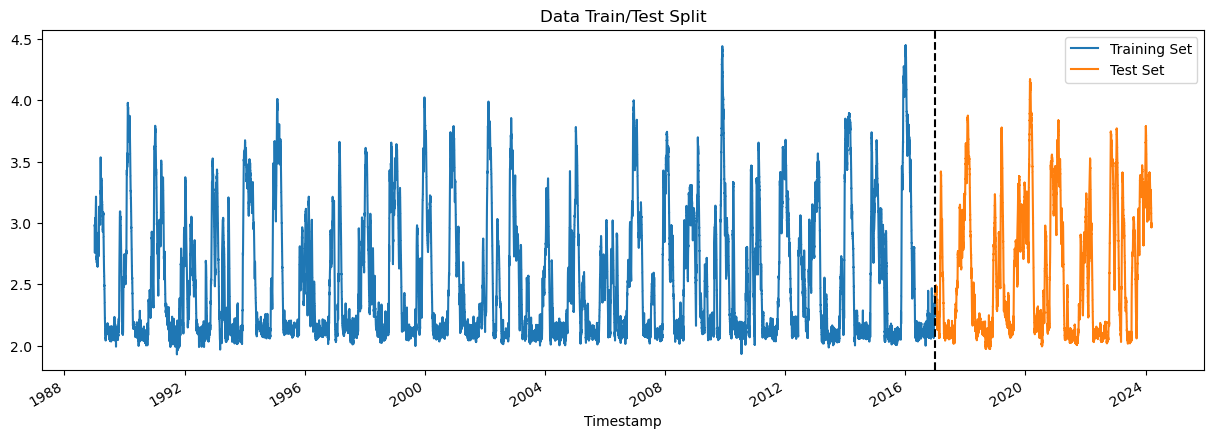

In [13]:
train = df.loc[df.index < '01-01-2017']
test = df.loc[df.index >= '01-01-2017']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')

ax.axvline('01-01-2017', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()


In [47]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12672 entries, 0 to 12671
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   level_0   12672 non-null  int64         
 1   index     12672 non-null  int64         
 2   Day       12672 non-null  datetime64[ns]
 3   Day Min   12672 non-null  float64       
 4   Day Mean  12672 non-null  float64       
 5   Day Max   12672 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 594.1 KB


In [45]:
# weekly plot, or monthly - March 2024
df_daily.loc[(df_daily.index > '01-03-2024') & (df_daily.index <= '31-03-2024')].plot(title='Month of Data') 
plt.show()

# the weekly seems trivial, but the monthly is relevant with the daily data.
# maybe I will revisit this and put in a number of months where we want some detail.
# quarterly here might actually be better, for the months where there is risk of flood water.

TypeError: Invalid comparison between dtype=int64 and str

### Feature Creation

In [15]:
df.index

DatetimeIndex(['1989-01-02 09:00:00+00:00', '1989-01-02 09:15:00+00:00',
               '1989-01-02 09:30:00+00:00', '1989-01-02 09:45:00+00:00',
               '1989-01-02 10:00:00+00:00', '1989-01-02 10:15:00+00:00',
               '1989-01-02 10:30:00+00:00', '1989-01-02 10:45:00+00:00',
               '1989-01-02 11:00:00+00:00', '1989-01-02 11:15:00+00:00',
               ...
               '2024-03-13 22:15:00+00:00', '2024-03-13 22:30:00+00:00',
               '2024-03-13 22:45:00+00:00', '2024-03-13 23:00:00+00:00',
               '2024-03-13 23:15:00+00:00', '2024-03-13 23:30:00+00:00',
               '2024-03-13 23:45:00+00:00', '2024-03-14 00:00:00+00:00',
               '2024-03-14 00:15:00+00:00', '2024-03-14 00:30:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Timestamp', length=1218710, freq=None)

In [16]:
df2.index

DatetimeIndex(['1989-01-02', '1989-01-03', '1989-01-04', '1989-01-05',
               '1989-01-06', '1989-01-07', '1989-01-08', '1989-01-09',
               '1989-01-10', '1989-01-11',
               ...
               '2024-03-04', '2024-03-05', '2024-03-06', '2024-03-07',
               '2024-03-08', '2024-03-09', '2024-03-10', '2024-03-11',
               '2024-03-12', '2024-03-13'],
              dtype='datetime64[ns]', name='Day', length=12855, freq=None)

In [46]:
def create_features(df):
    '''
    Create time series features based on time series index.
    '''
    df = df.copy()
    df['hour'] = df.index.hour # trivial for waterlevels
    df['dayofweek'] = df.index.day_of_week # trivial for waterlevels
    df['quarter'] = df.index.quarter # not interesting for waterlevels
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.day_of_year
    return df



def create_features_simple(df):
    '''
    Create time series features based on time series index.
    The function that looks at the average daily values can be used for year on year comparison
    '''    
    df['dayofweek'] = df.index.day_of_week # trivial for waterlevels
    df['quarter'] = df.index.quarter # not interesting for waterlevels
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.day_of_year
    return df



In [ ]:
df = create_features(df)
df2 = create_features_simple(df2)

In [18]:
df.tail(10)

#Timestamp  Value  hour  dayofweek  \
Timestamp                                                                     
2024-03-13 22:15:00+00:00  2024-03-13T22:15:00.000Z  2.990    22          2   
2024-03-13 22:30:00+00:00  2024-03-13T22:30:00.000Z  2.991    22          2   
2024-03-13 22:45:00+00:00  2024-03-13T22:45:00.000Z  2.991    22          2   
2024-03-13 23:00:00+00:00  2024-03-13T23:00:00.000Z  2.991    23          2   
2024-03-13 23:15:00+00:00  2024-03-13T23:15:00.000Z  2.993    23          2   
2024-03-13 23:30:00+00:00  2024-03-13T23:30:00.000Z  2.994    23          2   
2024-03-13 23:45:00+00:00  2024-03-13T23:45:00.000Z  2.994    23          2   
2024-03-14 00:00:00+00:00  2024-03-14T00:00:00.000Z  2.995     0          3   
2024-03-14 00:15:00+00:00  2024-03-14T00:15:00.000Z  2.996     0          3   
2024-03-14 00:30:00+00:00  2024-03-14T00:30:00.000Z  2.995     0          3   

                           quarter  month  year  dayofyear  
Timestamp                                                   
2024-03-13 22:15:00+00:00        1      3  2024         73  
2024-03-13 22:30:00+00:00        1      3  2024         73  
2024-03-13 22:45:00+00:00        1      3  2024         73  
2024-03-13 23:00:00+00:00        1      3  2024         73  
2024-03-13 23:15:00+00:00        1      3  2024         73  
2024-03-13 23:30:00+00:00        1      3  2024         73  
2024-03-13 23:45:00+00:00        1      3  2024         73  
2024-03-14 00:00:00+00:00        1      3  2024         74  
2024-03-14 00:15:00+00:00        1      3  2024         74  
2024-03-14 00:30:00+00:00        1      3  2024         74

In [19]:
df2.tail(10)

Day Min  Day Mean  Day Max  dayofweek  quarter  month  year  \
Day                                                                       
2024-03-04    3.207      3.23    3.251          0        1      3  2024   
2024-03-05    3.180      3.20    3.217          1        1      3  2024   
2024-03-06    3.204      3.21    3.221          2        1      3  2024   
2024-03-07    3.178      3.19    3.206          3        1      3  2024   
2024-03-08    3.140      3.16    3.180          4        1      3  2024   
2024-03-09    3.092      3.12    3.141          5        1      3  2024   
2024-03-10    3.035      3.07    3.093          6        1      3  2024   
2024-03-11    2.977      3.00    3.035          0        1      3  2024   
2024-03-12    2.967      2.97    2.978          1        1      3  2024   
2024-03-13    2.963      2.97    2.984          2        1      3  2024   

            dayofyear  
Day                    
2024-03-04         64  
2024-03-05         65  
2024-03-06         66  
2024-03-07         67  
2024-03-08         68  
2024-03-09         69  
2024-03-10         70  
2024-03-11         71  
2024-03-12         72  
2024-03-13         73

### Visualise our feature / target relationship

Text(0.5, 1.0, 'Waterlevel in M')

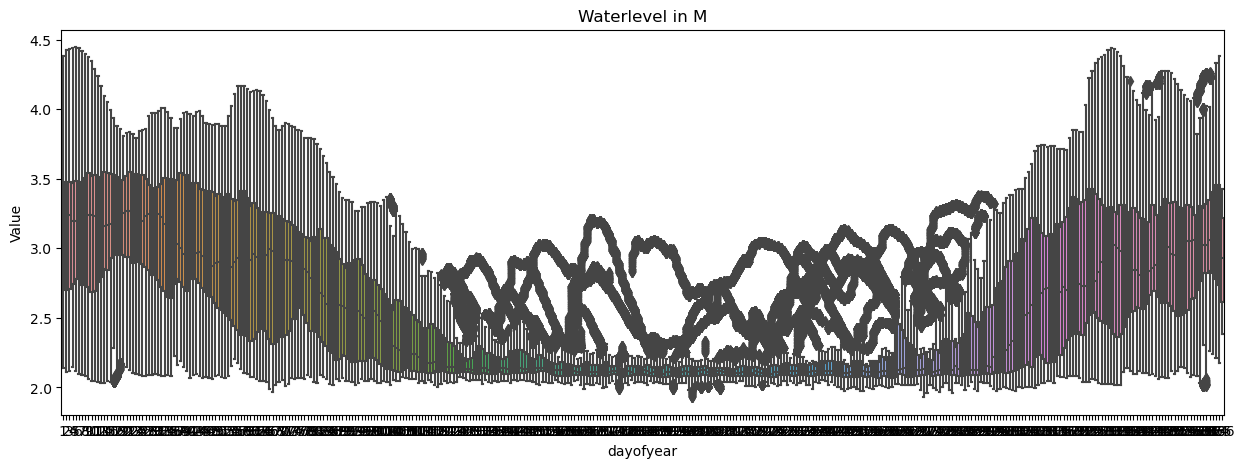

In [20]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=df, x='dayofyear', y='Value') #whis=(1, 99)
ax.set_title('Waterlevel in M')
# this example here is too detailed, maybe I need to calculate a weekly average from the average of the daily averages.
# another trivial example here if I explore the other dataset.

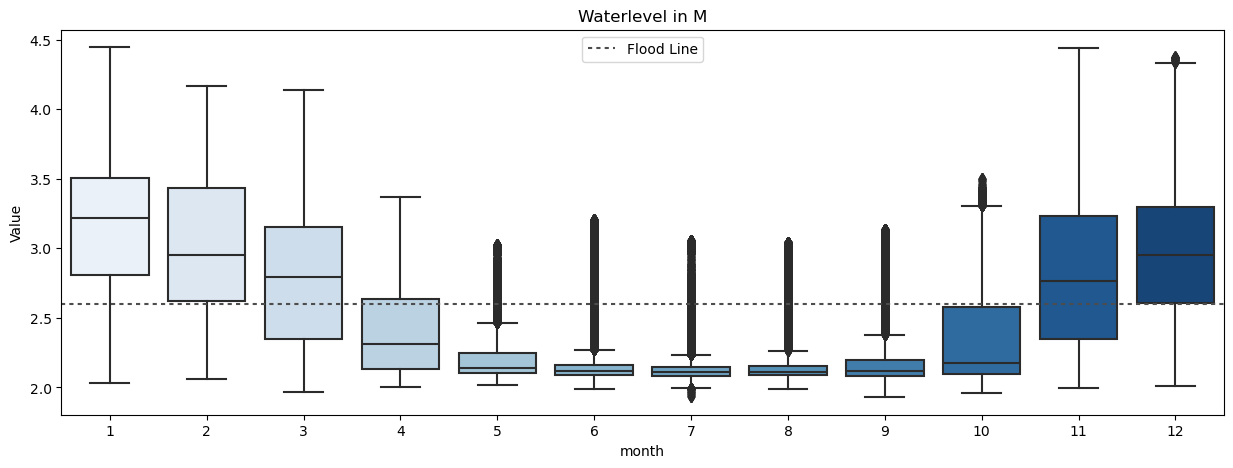

In [21]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=df, x='month', y='Value', palette='Blues') # not sure if the whiskers and outliers ok. whis=(2, 98)
ax.set_title('Waterlevel in M')
# I should put in the floodline here, for average projection of flooding in the future
# this is an absolute guess for first order approximation.
ax.axhline(2.6, color=".3", dashes=(2, 2), label='Flood Line')
plt.legend()
plt.show()

There is more scope for plots here, insert lines for percentiles, day of the year trends, quarterly and monthly year on year comparison looking for waterlevels websites definition for what is in flood and our estimation for flood levels in the field.

I am starting with the 5 number summary, and I can add in those as lines in a second plot.

In [22]:
# should I count the numbers of outliers in the summer months? This box plot and the one above seem to show them, is that enough for me?

In [23]:
# calculate and print the 5 number summaries
'''
quartiles = np.percentile(df['Value'], [25, 50, 75])
data_min, data_max = df['Value'].min(), df['Value'].max()

# print 5-number summary
print('Min: %.3f' % data_min)
print('Q1: %.3f' % quartiles[0])
print('Median: %.3f' % quartiles[1])
print('Q3: %.3f' % quartiles[2])
print('Max: %.3f' % data_max)
'''

#def summary(data): # more concise
#    '''Seven-number summary, printing the results'''

##    return np.percentile(data, [0, 10, 25, 50, 75, 90, 100], method="midpoint")
#print([0, 10, 25, 50, 75, 90, 100])
#print(summary(df['Value']))

[0, 10, 25, 50, 75, 90, 100]
[1.93  2.08  2.113 2.289 2.907 3.372 4.446]


In [24]:
# How do these compare to the ones on the Waterlevels website?

### My Chosen Model / Models
##### Regression model

In [25]:
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = ['Value']

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

# https://machinelearningmastery.com/tune-learning-rate-for-gradient-boosting-with-xgboost-in-python/
# I might edit this further, its KFOLD mixed in with SearchGrid, so I can check a number of hyperparameters.
# I am not sure how much time I should spend on the hyperparameters, I will plot some predicted points first and make the call.
# I can then exclude the test/train split, and the above notes on CV.


In [26]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50) # is this accurate enough in this case?
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=25)

[0]	validation_0-rmse:1.47761	validation_1-rmse:1.55768
[25]	validation_0-rmse:0.14186	validation_1-rmse:0.63322
[50]	validation_0-rmse:0.09427	validation_1-rmse:0.63714
[57]	validation_0-rmse:0.08549	validation_1-rmse:0.63803


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

I suspect there is overfitting here, so I will try again.

In [27]:
reg = xgb.XGBRegressor(n_estimators=3000, 
                       early_stopping_rounds=50,
                       learning_rate=0.005) # Regularization
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:2.07732	validation_1-rmse:2.17135
[100]	validation_0-rmse:1.28012	validation_1-rmse:1.37040
[200]	validation_0-rmse:0.80498	validation_1-rmse:0.93854
[300]	validation_0-rmse:0.52674	validation_1-rmse:0.72806
[400]	validation_0-rmse:0.37168	validation_1-rmse:0.64330
[500]	validation_0-rmse:0.28924	validation_1-rmse:0.61498
[600]	validation_0-rmse:0.24587	validation_1-rmse:0.60951
[655]	validation_0-rmse:0.22973	validation_1-rmse:0.60947


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=3000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [28]:
# I'm going to try gridsearch to get the best hyperparameters.

In [ ]:
reg_cv = GridSearchCV(reg, {'max_depth': [3,4,6], 'n_estimators': [500,1000,2000,3000]}, verbose=100)

reg_cv.fit(X_train,y_train, eval_set=[(X_train, y_train), (X_test, y_test)]) # put the verbose here instead

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START max_depth=3, n_estimators=500..............................
[0]	validation_0-rmse:2.07739	validation_1-rmse:2.17180
[1]	validation_0-rmse:2.06731	validation_1-rmse:2.16171
[2]	validation_0-rmse:2.05728	validation_1-rmse:2.15168
[3]	validation_0-rmse:2.04730	validation_1-rmse:2.14170
[4]	validation_0-rmse:2.03738	validation_1-rmse:2.13176
[5]	validation_0-rmse:2.02750	validation_1-rmse:2.12189
[6]	validation_0-rmse:2.01768	validation_1-rmse:2.11206
[7]	validation_0-rmse:2.00791	validation_1-rmse:2.10229
[8]	validation_0-rmse:1.99818	validation_1-rmse:2.09257
[9]	validation_0-rmse:1.98851	validation_1-rmse:2.08290
[10]	validation_0-rmse:1.97889	validation_1-rmse:2.07329
[11]	validation_0-rmse:1.96931	validation_1-rmse:2.06372
[12]	validation_0-rmse:1.95979	validation_1-rmse:2.05420
[13]	validation_0-rmse:1.95031	validation_1-rmse:2.04474
[14]	validation_0-rmse:1.94089	validation_1-rmse:2.03533
[15]	validati

In [ ]:
reg_cv.best_params_

In [ ]:
gbm = xgb.XGBRegressor(**reg_cv.best_params_) # theres no learning rate, should I use gridsearch and try and include them?

gbm.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=20)

In [ ]:
predictions = gbm.predict(X_test)
predictions.shape # predicted water levels, but for how long?
predictions

#### Evaluate Scores

In [ ]:
gbm.score(X_train,y_train)

In [ ]:
gbm.score(X_test,y_test) # potential issues here.
# should I try to get early stopping and the other hyperparameters back in?
# maybe I should continue first with predictions based on the performance I managed first

Here are a few scenarios where you might observe a negative R^2 score:

Model is performing very poorly: The model might not be capturing any of the variance in the target variable or might be capturing it in the wrong direction. In such cases, the model is worse than a horizontal line (mean prediction), resulting in a negative R^2 score.

Data preprocessing issues: Negative R^2 scores can sometimes indicate problems with data preprocessing. For instance, if there's a mismatch between the features and the target variable, or if the target variable is transformed in a way that makes it hard for the model to learn patterns, it could result in negative scores.

Random chance: In some rare cases, particularly with very small datasets, a negative R^2 score might occur due to random chance.

If you encounter a negative R^2 score, it's crucial to investigate why this might be happening. It could be indicative of underlying issues with the model, the data, or the modeling process itself. In such cases, it's often helpful to revisit the data preprocessing steps, the model architecture, and consider if additional features or more data could improve model performance. Additionally, cross-validation or further evaluation metrics can provide more insights into the model's performance.

In [ ]:
# need to add in the predicted points here for a few months and see what it looks like.

### Feature Importances

In [ ]:
# this is not really interesting but worth looking at briefly.
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['importance'])

fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()    

This is showing that breaking down the first dataset into hour or day of the week is trivial. Using the day of the year, and similarly its quater and months can be handy. The year is also important, and I will investigate by looking at the flood windows by year on year.

## Exploratory Data Analysis - Water Temperature

In [17]:
df = df_temp.copy() # copy the dataframe from when it was called earlier above.

# first inspection of the data
print('      Dataset      ')
print('------------------------')
print(f'Number of samples   : {df.shape[0]}')
print(f'Number of attributes: {df.shape[1]}')
print()

      Dataset      
------------------------
Number of samples   : 80429
Number of attributes: 2



In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 80429 entries, 2015-02-02 00:00:00+00:00 to 2024-05-10 16:00:00+00:00
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Value         80400 non-null  float64
 1   Quality Code  80429 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 1.8 MB


In [19]:
df_total = df.isnull().sum().sort_values(ascending=False)
df_percent = 100.0*(df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat([df_total, df_percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(30)

Total   Percent
Value            29  0.036057
Quality Code      0  0.000000

I want to examine the range of values, as the quality code might indicate some incorrect work when repairs were being done. I see some missing values

In [33]:
# Create an empty DataFrame to store the value counts
value_counts_df = pd.DataFrame(columns=['Feature', 'Value', 'Count'])

# Create an empty list
data = []

# Loop through each categorical feature
for feature in df.columns:
    # Calculate value counts for the current feature
    counts = df[feature].value_counts()
    
    # Loop through each value count
    for value, count in counts.items():
        # Check if the count is outside the range [2, 20]
        if value < 2 or value > 20:
            # Append the feature, value, and count to the list as a dictionary
            data.append({'Feature': feature, 'Value': value, 'Count': count})

value_counts_df = pd.DataFrame(data)

print(value_counts_df.to_string(index=False))

     Feature  Value  Count
       Value   20.2     20
       Value   20.1     14
       Value   20.3     12
       Value   20.4     11
       Value    0.0     10
       Value   20.6      4
       Value   20.7      3
       Value   20.5      2
       Value   20.8      1
Quality Code  254.0  80400
Quality Code   -1.0     29


So the minus one quality code appears 29 times and needs to be dropped, as does the value of 0 degrees that comes up 10 times. It was ten consecutive hours, and does not represent anything interesting. It can be dropped. For other weather stations maybe it can be something more interesting.

In [36]:
df.sort_values('Value', ascending=True).head(15)

Value  Quality Code
Timestamp                                     
2016-09-23 22:00:00+00:00    0.0           254
2016-09-23 16:00:00+00:00    0.0           254
2016-09-23 17:00:00+00:00    0.0           254
2016-09-23 18:00:00+00:00    0.0           254
2016-09-24 01:00:00+00:00    0.0           254
2016-09-24 00:00:00+00:00    0.0           254
2016-09-23 23:00:00+00:00    0.0           254
2016-09-23 19:00:00+00:00    0.0           254
2016-09-23 20:00:00+00:00    0.0           254
2016-09-23 21:00:00+00:00    0.0           254
2018-01-08 12:00:00+00:00    4.4           254
2018-01-08 11:00:00+00:00    4.4           254
2018-01-08 14:00:00+00:00    4.4           254
2018-01-08 13:00:00+00:00    4.4           254
2018-01-08 10:00:00+00:00    4.4           254

In [41]:
# Drop rows where the value of the column 'Value' is zero and 'Quality Code' is -1
df = df[(df['Value'] != 0) & (df['Quality Code'] != -1)]

df.info()
# should now be showing 80,390 rows

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 80390 entries, 2015-02-02 00:00:00+00:00 to 2024-05-10 16:00:00+00:00
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Value         80390 non-null  float64
 1   Quality Code  80390 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 1.8 MB


### Data Visualization

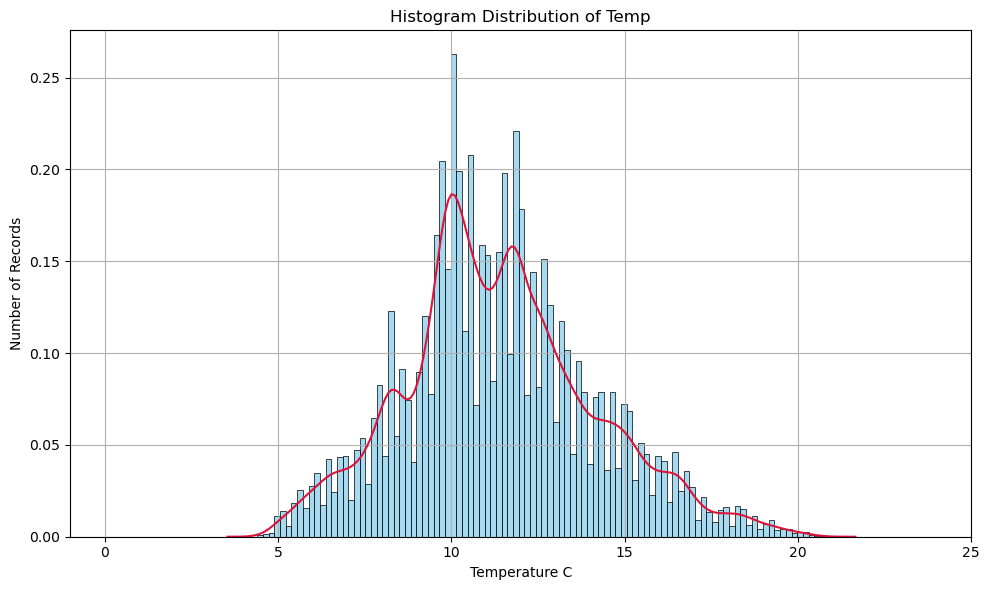

In [99]:
# Distribution of temp
plt.figure(figsize=(10, 6))
#sns.histplot(df["Value"], kde=True, bins=100, color='skyblue', edgecolor='black')

ax = sns.histplot(data=df, x="Value", kde=False, stat='density', bins=100, color='skyblue', edgecolor='black')
sns.kdeplot(data=df, x="Value", color='crimson', ax=ax)

plt.title('Histogram Distribution of Temp')

plt.xlabel('Temperature C')
plt.ylabel('Number of Records')

plt.grid(True)
plt.xlim(-1, 25)
plt.tight_layout()
plt.show()



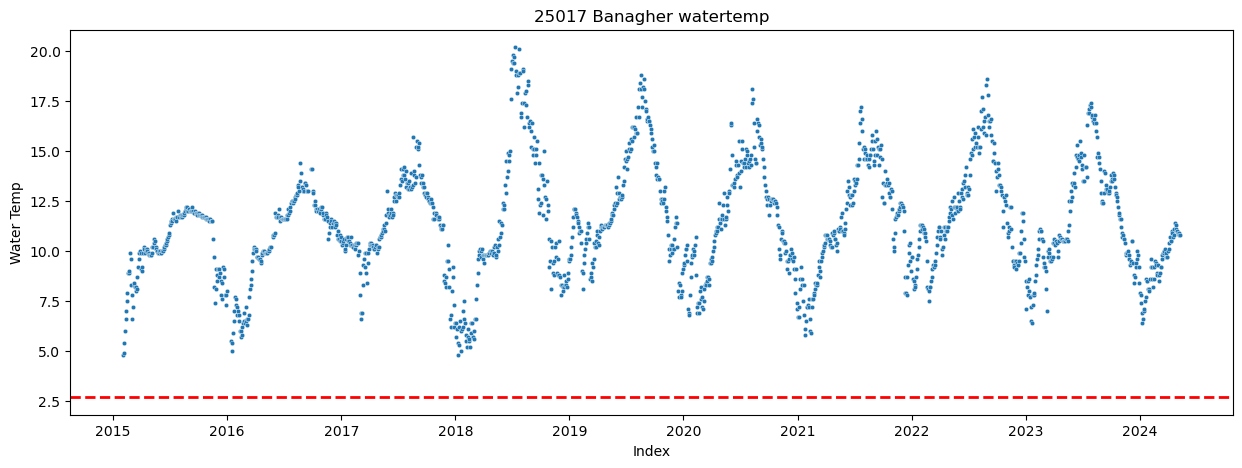

In [44]:
df_one_point = df.iloc[::48] # every 24th point to keep it simpler for this plot

#sns.set(style="whitegrid")
plt.figure(figsize=(15, 5))
sns.scatterplot(data=df_one_point, x=df_one_point.index, y='Value', s=10, palette=colour_pal)

plt.axhline(y=field_flood, color='red', linestyle='--', linewidth=2) # mark this name
# add quartile lines
plt.title('25017 Banagher watertemp')
plt.xlabel('Index')
plt.ylabel('Water Temp')

# Show the plot
plt.show()

Very Clearly Cyclical as to be expected

In [47]:
# encoding features from the function described above
df = create_features(df)

In [100]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 80390 entries, 2015-02-02 00:00:00+00:00 to 2024-05-10 16:00:00+00:00
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Value         80390 non-null  float64
 1   Quality Code  80390 non-null  int64  
 2   hour          80390 non-null  int32  
 3   dayofweek     80390 non-null  int32  
 4   quarter       80390 non-null  int32  
 5   month         80390 non-null  int32  
 6   year          80390 non-null  int32  
 7   dayofyear     80390 non-null  int32  
 8   day_sin       80390 non-null  float64
 9   day_cos       80390 non-null  float64
dtypes: float64(3), int32(6), int64(1)
memory usage: 4.9 MB


Value  Quality Code          hour     dayofweek       quarter  \
count  80390.000000       80390.0  80390.000000  80390.000000  80390.000000   
mean      11.378820         254.0     11.499527      2.997015      2.478878   
std        2.750626           0.0      6.922518      1.999805      1.119976   
min        4.400000         254.0      0.000000      0.000000      1.000000   
25%        9.700000         254.0      5.000000      1.000000      1.000000   
50%       11.200000         254.0     11.500000      3.000000      2.000000   
75%       13.000000         254.0     17.000000      5.000000      3.000000   
max       20.800000         254.0     23.000000      6.000000      4.000000   

              month          year     dayofyear       day_sin       day_cos  
count  80390.000000  80390.000000  80390.000000  80390.000000  80390.000000  
mean       6.435800   2019.262520    180.422839      0.028366      0.003616  
std        3.444053      2.683219    105.236816      0.712583      0.701014  
min        1.000000   2015.000000      1.000000     -0.999991     -0.999963  
25%        3.000000   2017.000000     89.000000     -0.687053     -0.683919  
50%        6.000000   2019.000000    178.000000      0.043022      0.004304  
75%        9.000000   2022.000000    272.000000      0.752667      0.702527  
max       12.000000   2024.000000    366.000000      0.999991      1.000000

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


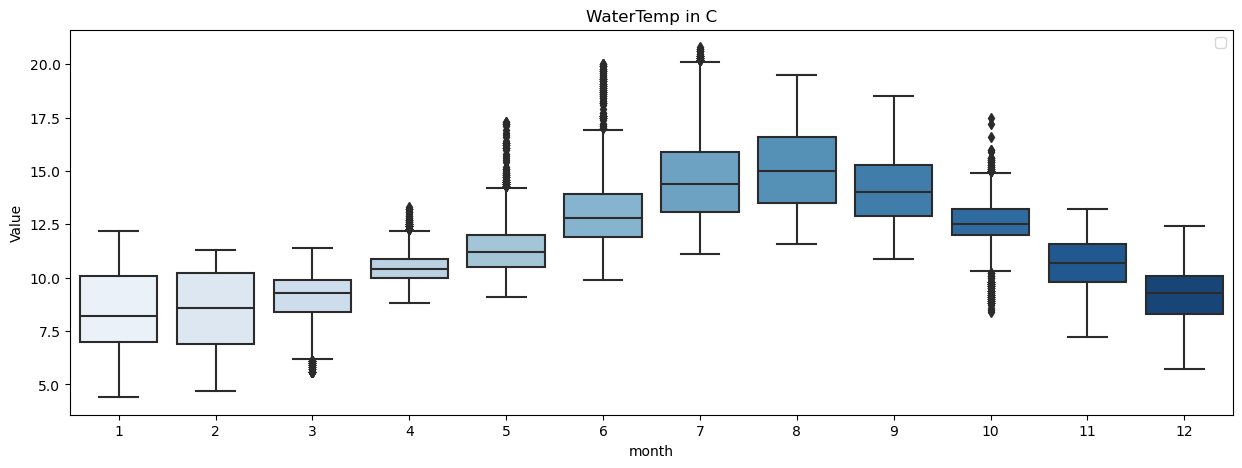

In [48]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=df, x='month', y='Value', palette='Blues')
ax.set_title('WaterTemp in C')
#ax.axhline(2.6, color=".3", dashes=(2, 2), label='Flood Line')
plt.legend()
plt.show()

In [54]:
# Encode day of the year using sine and cosine transformations
df['day_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365.0)
df['day_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365.0)

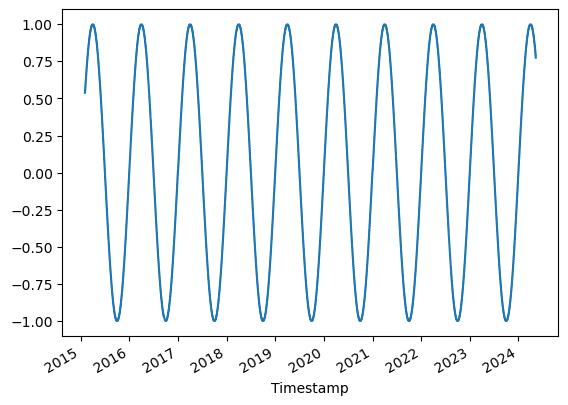

In [55]:
ax = df['day_sin'].plot()

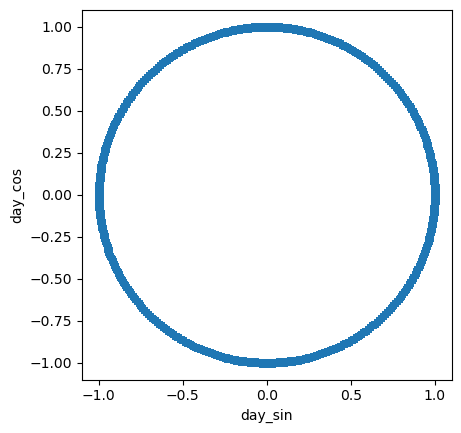

In [57]:
#ax = df.plot.scatter('day_sin', 'day_cos').set_aspect('equal')

scale_mapper = {
    "jan": 'Winter', "feb": 'Winter', "mar": 'Spring',
    "apr": 'Spring', "may": 'Spring', "jun": 'Summer',
    "jul": 'Summer', "aug": 'Summer', "sep": 'Autumn',
    "oct": 'Autumn', "nov": 'Autumn', "dec": 'Winter',
}

df['season'] = df['month'].replace(scale_mapper)  #adding a season for better generalisation

scale_mapper2 = {
    "jan": 1, "feb": 2, "mar": 3, "apr": 4, "may": 5, "jun": 6,
    "jul": 7, "aug": 8, "sep": 9, "oct": 10, "nov": 11, "dec": 12,
}

df['monthnum'] = df['month'].replace(scale_mapper2)  #adding numeric months to allow for easier sorting 

#Build a circle plot to look at the distribution by month

colors = {'Winter': 'blue', 'Spring': 'green', 'Summer': 'orange', 'Autumn': 'brown'}
df['angle'] = (df['monthnum'] - 1) * (360 / 12)  # Calculate angle for each month
df['frequency'] = df.groupby('monthnum')['monthnum'].transform('size')

df['color'] = df['season'].map(colors)
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)  # Create polar subplot

ax.scatter(np.radians(df['angle']), np.ones_like(df['angle']), s=df['frequency'] * 5, c=df['color'], alpha=0.7)

for idx, row in df.iterrows():
    month_label = str(row['month'])
    ax.text(np.radians(row['angle']),1.1, month_label, ha='center', va='center')

#Setting the direction of the angle to start from the top (o degrees)
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1) #clockwise direction
ax.grid(False) # Removal of radial gridlines and ticks
ax.set_yticks([])
plt.tight_layout()
plt.show()
#the circle plot is good to show here, however without a year field I am unsure asto what the interpretation is.



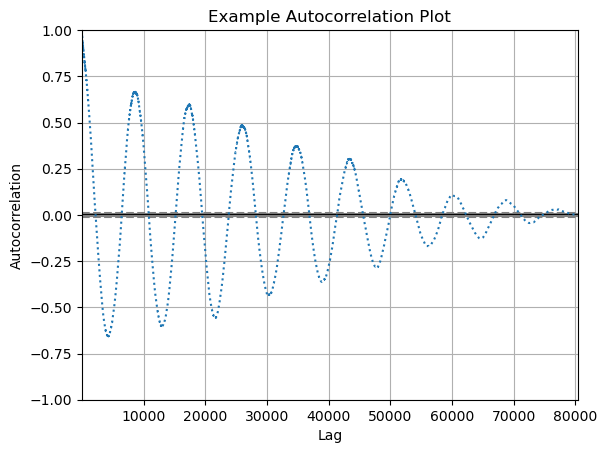

In [86]:
pd.plotting.autocorrelation_plot(df['Value'], linestyle = 'dotted')

# Display the plot
plt.title('Example Autocorrelation Plot')
plt.show()

In [89]:
plt.figure('Andrews Curve')

#pd.plotting.andrews_curves(df, 'Value', color=['r', 'g', 'b'])
plt.show()

<Figure size 640x480 with 0 Axes>

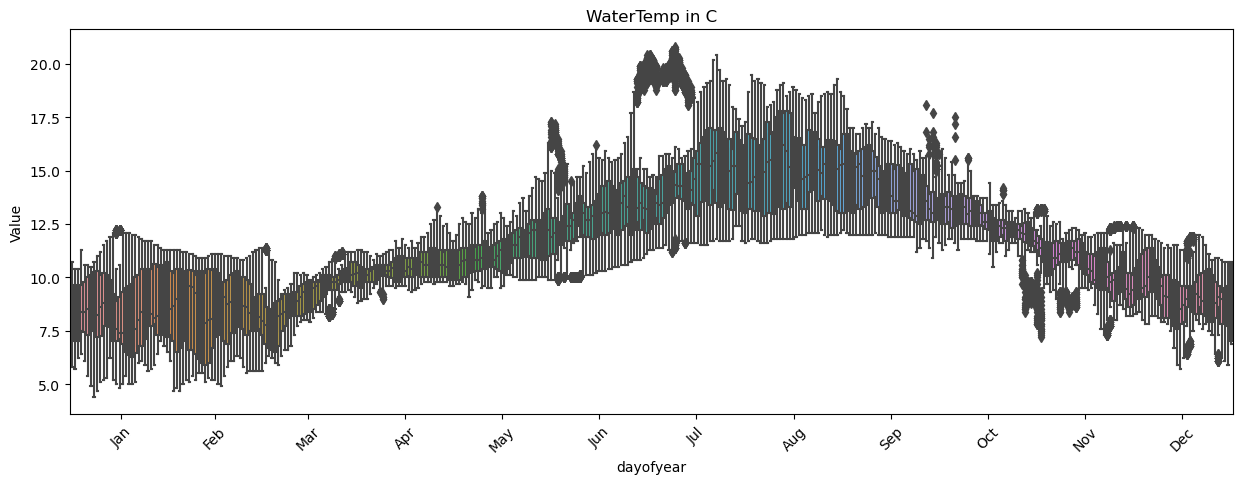

In [85]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=df, x='dayofyear', y='Value', ax=ax)  # Adjust 'whis' parameter if needed

# Set title
ax.set_title('WaterTemp in C')

# Rotate x-axis tick labels by 90 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Insert month names as x-axis ticks
# Example: If 'dayofyear' represents the day of the year, you can insert month names like this:
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
cumulative_days = [sum(days_in_month[:i]) for i in range(len(days_in_month) + 1)]
ax.set_xticks([(cumulative_days[i] + cumulative_days[i + 1]) / 2 for i in range(len(cumulative_days) - 1)])
ax.set_xticklabels(month_names)

# Show plot
plt.show()

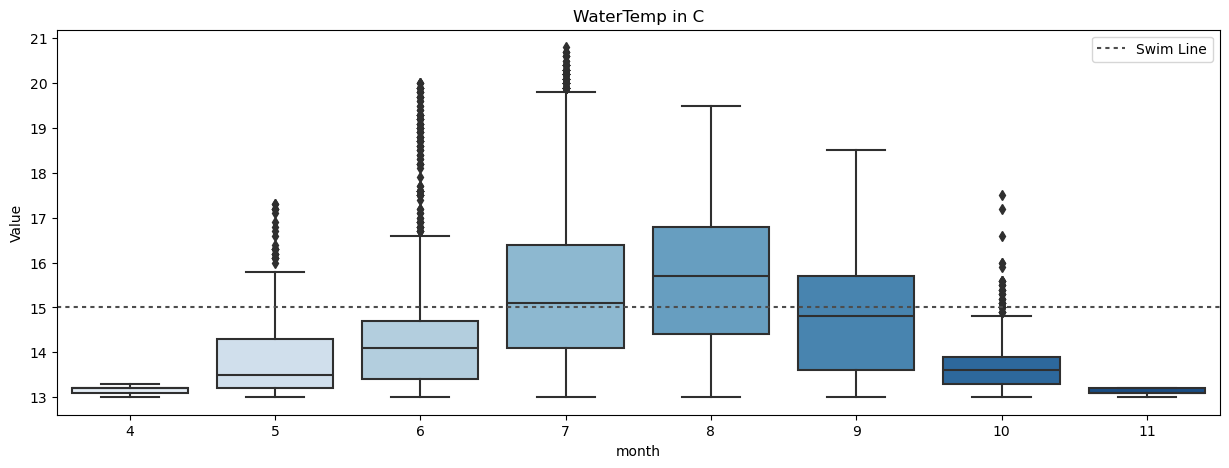

In [112]:
# Exclude values of 'Value' column below 13
filtered_df = df[df['Value'] >= 13]

fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=filtered_df, x='month', y='Value', palette='Blues')
ax.set_title('WaterTemp in C')
ax.axhline(15, color=".3", dashes=(2, 2), label='Swim Line')
plt.legend()
plt.show()

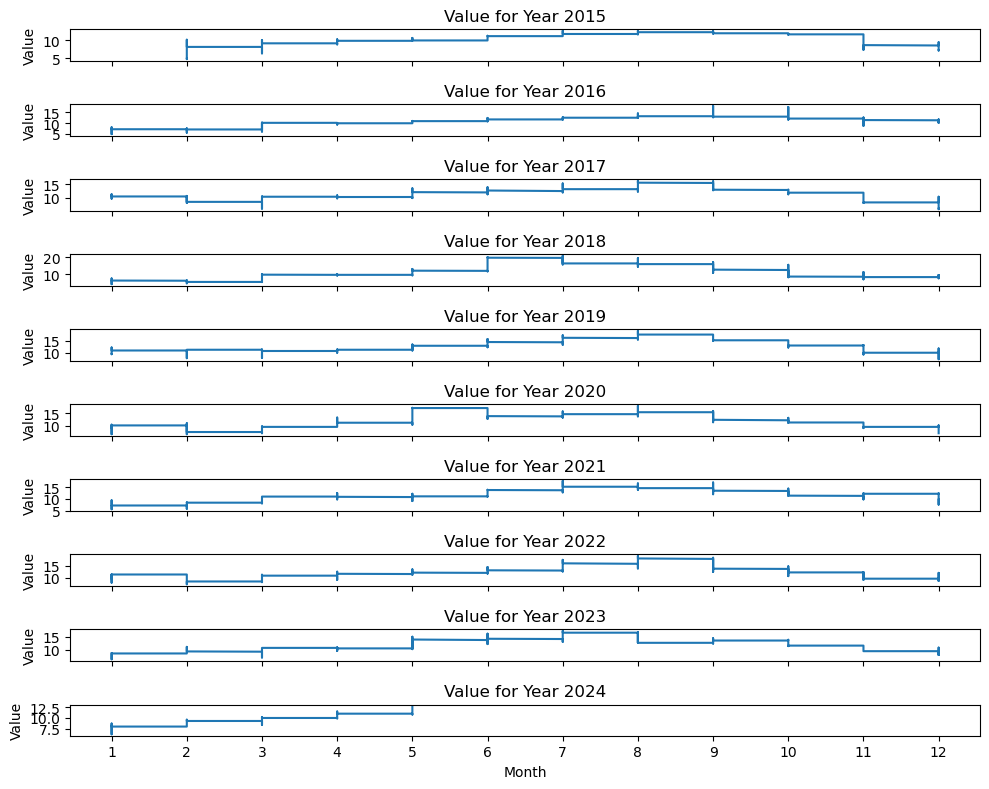

In [79]:
unique_years = df['year'].unique()

# Create subplots with shared x-axis
fig, axes = plt.subplots(len(unique_years), 1, sharex=True, figsize=(10, 8), gridspec_kw={'height_ratios': [6]*len(unique_years)})


# Iterate over unique years
for i, year in enumerate(unique_years):
    # Filter data for the current year
    year_data = df[df['year'] == year]
    
    # Plot 'Value' column for the current year on the corresponding subplot
    axes[i].plot(year_data['month'], year_data['Value'], label=f'Year {year}')
    
    # Set title for each subplot
    axes[i].set_title(f'Value for Year {year}')
    
    # Set ylabel for each subplot
    axes[i].set_ylabel('Value')

# Set common xlabel
axes[-1].set_xlabel('Month')

# Customize x-axis ticks to show only months
plt.xticks(ticks=df['month'].unique(), labels=df['month'].unique())  # Assuming 'month' column contains month names

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()